# Research Question B

This notebook tries to find an answer to the research question "What architectural designs allow for efficient parameter
editing in INRs without explicit decoding or sampling?".

**Make sure to enable GPU runtime in Colab: Runtime → Change runtime type → Hardware accelerator → GPU**


In [ ]:
!git clone https://github.com/VITA-Group/INSP.git

In [2]:
!pip install torch torchvision torchaudio
!pip install matplotlib opencv-python pillow tqdm numpy scipy
!pip install scikit-image kornia einops
!pip install glob2
!pip install sk-video
!pip install cmapy

In [3]:
# Import necessary libraries
import sys
import os

# Add INSP to path
sys.path.append('.')
sys.path.append('./INSP')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from functools import partial
import tqdm
from collections import OrderedDict
import time

# Import INSP modules
import dataio, modules, utils, training, loss_functions, diff_operators

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create directories for experiments
os.makedirs('experiment_data', exist_ok=True)
os.makedirs('logs', exist_ok=True)
os.makedirs('grad_exports', exist_ok=True)
os.makedirs('results', exist_ok=True)



Using device: cuda


## Helper Functions


In [4]:
def get_mgrid(sidelen, dim=2):
    """Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1."""
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors, indexing='ij'), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

def get_cameraman_image(size=256):
    """Get the cameraman image from INSP dataio and resize to specified size"""
    # Create Camera dataset and get the image
    camera_dataset = dataio.Camera()
    cameraman_pil = camera_dataset[0]

    # Convert to numpy array and normalize
    cameraman_np = np.array(cameraman_pil) / 255.0

    # Resize to desired size
    if cameraman_np.shape[0] != size:
        cameraman_resized = cv2.resize(cameraman_np, (size, size), interpolation=cv2.INTER_AREA)
    else:
        cameraman_resized = cameraman_np

    return cameraman_resized

def add_noise(img, noise_level=0.1):
    """Add Gaussian noise to image"""
    noise = np.random.normal(0, noise_level, img.shape)
    return np.clip(img + noise, 0, 1)

def add_blur(img, kernel_size=15):
    """Add Gaussian blur to image"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def add_inpainting_mask(img, mask_ratio=0.3):
    """Add random holes for inpainting task"""
    mask = np.random.uniform(size=img.shape) > mask_ratio
    return img * mask

def visualize_images(images, titles, figsize=(15, 5)):
    """Visualize multiple images side by side"""
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    if len(images) == 1:
        axes = [axes]

    for i, (img, title) in enumerate(zip(images, titles)):
        axes[i].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes[i].set_title(title)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

def save_image(img, path):
    """Save image to file"""
    img_uint8 = (np.clip(img, 0, 1) * 255).astype(np.uint8)
    Image.fromarray(img_uint8).save(path)

def calculate_mae(img1, img2):
    """Calculate Mean Absolute Error between two images"""
    if torch.is_tensor(img1):
        img1 = img1.cpu().numpy()
    if torch.is_tensor(img2):
        img2 = img2.cpu().numpy()
    return np.mean(np.abs(img1 - img2))

def calculate_mse(img1, img2):
    """Calculate Mean Squared Error between two images"""
    if torch.is_tensor(img1):
        img1 = img1.cpu().numpy()
    if torch.is_tensor(img2):
        img2 = img2.cpu().numpy()
    return np.mean((img1 - img2) ** 2)

def calculate_psnr(img1, img2):
    """Calculate Peak Signal-to-Noise Ratio between two images"""
    mse = calculate_mse(img1, img2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(1.0 / np.sqrt(mse))


## Step 1: Load Cameraman Image and Create Corrupted Versions


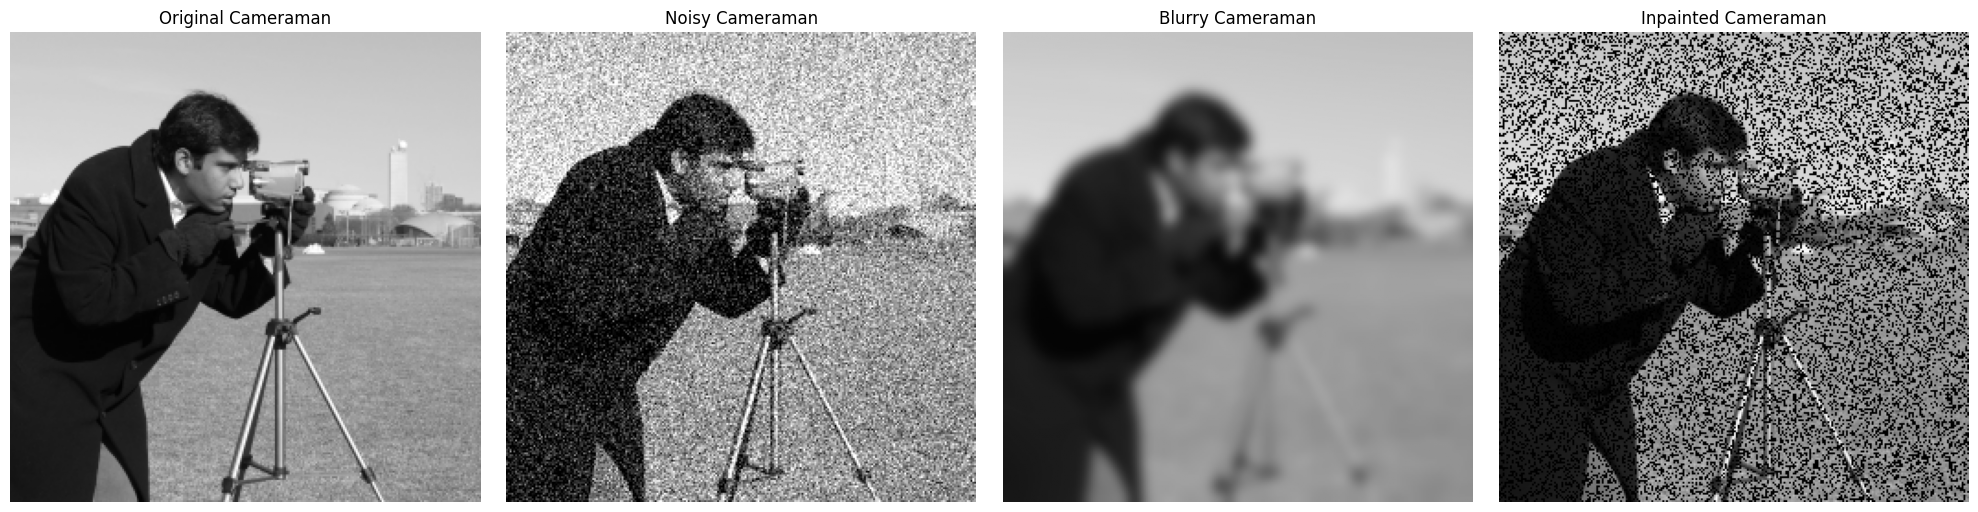

In [5]:
# Load the cameraman image from INSP dataio
original_img = get_cameraman_image(256)

# Create corrupted versions of the cameraman image
noisy_img = add_noise(original_img, noise_level=0.15)
blurry_img = add_blur(original_img, kernel_size=21)
inpainted_img = add_inpainting_mask(original_img, mask_ratio=0.3)

# Save images
save_image(original_img, 'experiment_data/cameraman_original.png')
save_image(noisy_img, 'experiment_data/cameraman_noisy.png')
save_image(blurry_img, 'experiment_data/cameraman_blurry.png')
save_image(inpainted_img, 'experiment_data/cameraman_inpainted.png')

# Visualize the cameraman image and its corrupted versions
visualize_images(
    [original_img, noisy_img, blurry_img, inpainted_img],
    ['Original Cameraman', 'Noisy Cameraman', 'Blurry Cameraman', 'Inpainted Cameraman'],
    figsize=(20, 5)
)


## Step 2: Custom Dataset Class for Cameraman Image Experiments


In [6]:
class CameramanDataset:
    """Dataset class specifically for cameraman image experiments"""
    def __init__(self, img_type='original'):
        self.img_type = img_type

        # Load the appropriate cameraman image
        if img_type == 'noisy':
            img = Image.open('experiment_data/cameraman_noisy.png').convert('L')
        elif img_type == 'blurry':
            img = Image.open('experiment_data/cameraman_blurry.png').convert('L')
        elif img_type == 'inpainted':
            img = Image.open('experiment_data/cameraman_inpainted.png').convert('L')
        else:
            img = Image.open('experiment_data/cameraman_original.png').convert('L')

        self.img = np.array(img) / 255.0  # Normalize to [0, 1]
        self.img_channels = 1  # Grayscale

        print(f"Loaded {img_type} cameraman image: shape {self.img.shape}")

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.img


## Step 3: Train SIREN INRs on Corrupted Images


In [7]:
def reconstruct_from_siren(model, sz=256):
    """Reconstruct image from trained SIREN model"""
    model.eval()

    # Create coordinate grid
    coords = get_mgrid(sz, 2).to(device).unsqueeze(0)

    with torch.no_grad():
        # Get model output
        model_input = {'coords': coords}
        model_output = model(model_input)
        reconstruction = model_output['model_out']

        # Reshape to image
        reconstruction = reconstruction.squeeze().cpu().numpy().reshape(sz, sz)

    return np.clip(reconstruction, 0, 1)

def calculate_metrics(img1, img2):
    """Calculate MAE, MSE, and PSNR between two images"""
    # Ensure images are numpy arrays
    if torch.is_tensor(img1):
        img1 = img1.cpu().numpy()
    if torch.is_tensor(img2):
        img2 = img2.cpu().numpy()

    # Calculate metrics
    mae = np.mean(np.abs(img1 - img2))
    mse = np.mean((img1 - img2) ** 2)

    # PSNR calculation
    if mse == 0:
        psnr = float('inf')
    else:
        psnr = 20 * np.log10(1.0 / np.sqrt(mse))

    return mae, mse, psnr

def train_siren_inr_with_early_stopping(img_type, epochs=500, lr=1e-4, hidden_features=256,
                    early_stop_mse=1e-5, show_reconstruction=True):

    print(f"Training SIREN INR for {img_type} cameraman image...")
    print(f"Early stopping criterion: MSE < {early_stop_mse}")

    # Start timing
    start_time = time.time()

    # Create cameraman dataset
    img_dataset = CameramanDataset(img_type)

    # Wrap with INSP's coordinate wrapper
    coord_dataset = dataio.Implicit2DWrapper(
        img_dataset,
        sidelength=256,
        compute_diff='gradients'
    )

    # Create dataloader
    dataloader = DataLoader(
        coord_dataset,
        shuffle=True,
        batch_size=4096,
        pin_memory=True,
        num_workers=0
    )

    # Create SIREN model
    model = modules.SingleBVPNet(
        type='sine',
        mode='mlp',
        sidelength=(256, 256),
        hidden_features=hidden_features,
        num_hidden_layers=3,
        out_features=1
    ).to(device)

    # Use INSP's original loss function
    loss_fn = partial(loss_functions.image_mse, None)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training directory
    model_dir = f'logs/siren_cameraman_{img_type}'
    os.makedirs(model_dir, exist_ok=True)

    # Get ground truth for comparison
    if img_type == 'noisy':
        ground_truth = noisy_img
    elif img_type == 'blurry':
        ground_truth = blurry_img
    elif img_type == 'inpainted':
        ground_truth = inpainted_img
    else:
        ground_truth = original_img

    model.train()
    convergence_epoch = epochs
    train_losses = []

    # Create progress bar
    pbar = tqdm.tqdm(range(epochs), desc=f"Training {img_type.capitalize()} Cameraman SIREN")

    for epoch in pbar:
        epoch_losses = []

        for step, (model_input, gt) in enumerate(dataloader):
            model_input = {key: value.cuda() for key, value in model_input.items()}
            gt = {key: value.cuda() for key, value in gt.items()}

            # Forward pass
            model_output = model(model_input)

            # Compute loss using INSP's loss function
            losses = loss_fn(model_output, gt)
            train_loss = losses['img_loss']

            # Backward pass
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            epoch_losses.append(train_loss.item())

        # Calculate average epoch loss
        avg_epoch_loss = np.mean(epoch_losses)
        train_losses.append(avg_epoch_loss)

        # Update progress bar with current loss
        pbar.set_postfix({'Loss': f'{avg_epoch_loss:.2e}', 'Best': f'{min(train_losses):.2e}'})

        # Check early stopping condition
        if avg_epoch_loss < early_stop_mse:
            convergence_epoch = epoch + 1
            pbar.set_description(f"Early Stopped - {img_type.capitalize()} Cameraman SIREN")
            pbar.set_postfix({'Final Loss': f'{avg_epoch_loss:.2e}', 'Epochs': convergence_epoch})
            break

    # Close progress bar
    pbar.close()

    # Calculate total training time
    total_time = time.time() - start_time

    print(f"Training completed in {convergence_epoch} epochs")
    print(f"Total training time: {total_time:.2f} seconds")

    # Save final model
    torch.save(model.state_dict(), os.path.join(model_dir, 'model_final.pth'))

    # Generate reconstruction and calculate metrics
    if show_reconstruction:
        print(f"Generating reconstruction and calculating metrics...")
        reconstruction = reconstruct_from_siren(model)

        # Calculate metrics comparing reconstruction to ground truth
        mae, mse, psnr = calculate_metrics(reconstruction, ground_truth)

        # Calculate metrics comparing reconstruction to original cameraman
        mae_orig, mse_orig, psnr_orig = calculate_metrics(reconstruction, original_img)

        # Print metrics
        print("\\n" + "="*50)
        print("TRAINING METRICS")
        print("="*50)
        print(f"Convergence Epoch: {convergence_epoch}/{epochs}")
        print(f"Total Training Time: {total_time:.2f} seconds")
        print(f"Time per Epoch: {total_time/convergence_epoch:.2f} seconds")
        print(f"Final Training Loss: {train_losses[-1]:.2e}")
        print(f"Best Training Loss: {min(train_losses):.2e}")

        print("RECONSTRUCTION vs INPUT IMAGE:")
        print(f"  MAE: {mae:.6f}")
        print(f"  MSE: {mse:.2e}")
        print(f"  PSNR: {psnr:.2f} dB")

        print("RECONSTRUCTION vs ORIGINAL CAMERAMAN:")
        print(f"  MAE: {mae_orig:.6f}")
        print(f"  MSE: {mse_orig:.2e}")
        print(f"  PSNR: {psnr_orig:.2f} dB")
        print("="*50)

        # Plot training loss curve
        plt.figure(figsize=(10, 6))
        epochs_range = range(1, len(train_losses) + 1)
        plt.plot(epochs_range, train_losses, 'b-', linewidth=2, label='Training Loss')

        if convergence_epoch < epochs:
            plt.axvline(x=convergence_epoch, color='r', linestyle='--', alpha=0.7,
                       label=f'Early Stopped (Epoch {convergence_epoch})')

        plt.xlabel('Epoch')
        plt.ylabel('Loss (MSE)')
        plt.title(f'Training Loss Curve - {img_type.capitalize()} Cameraman')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)
        plt.legend()

        # Add loss statistics
        initial_loss = train_losses[0]
        final_loss = train_losses[-1]
        min_loss = min(train_losses)

        plt.text(0.02, 0.98, f'Initial Loss: {initial_loss:.6f} \nMin Loss: {min_loss:.6f}',
                 transform=plt.gca().transAxes, verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

        plt.tight_layout()
        plt.show()

        # Visualize reconstruction
        visualize_images(
            [ground_truth, reconstruction],
            [f'{img_type.capitalize()} Input', f'SIREN Reconstruction - PSNR: {psnr:.1f} dB'],
            figsize=(10, 5)
        )

        # Save reconstruction
        save_image(reconstruction, f'experiment_data/siren_reconstruction_{img_type}.png')
        print(f"SIREN reconstruction saved for {img_type}")

    return model, model_dir

def train_siren_inr(img_type, epochs=500, lr=1e-4, hidden_features=256, show_reconstruction=True):
    """Wrapper function that calls training with early stopping"""
    return train_siren_inr_with_early_stopping(
        img_type, epochs, lr, hidden_features,
        early_stop_mse=1e-5, show_reconstruction=show_reconstruction
    )



STEP 1/3: Training SIREN for NOISY cameraman image
Training SIREN INR for noisy cameraman image...
Early stopping criterion: MSE < 1e-05
Loaded noisy cameraman image: shape (256, 256)
max of grid tensor(1.)
SingleBVPNet(
  (image_downsampling): ImageDownsampling()
  (net): FCBlock(
    (net): MetaSequential(
      (0): MetaSequential(
        (0): BatchLinear(in_features=2, out_features=256, bias=True)
        (1): Sine()
      )
      (1): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (2): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (3): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (4): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=1, bias=True)
      )
    )
  )
)


Training Noisy Cameraman SIREN: 100%|██████████| 3000/3000 [00:38<00:00, 77.98it/s, Loss=7.94e-05, Best=4.34e-05]


Training completed in 3000 epochs
Total training time: 38.62 seconds
Generating reconstruction and calculating metrics...
\n==================================================
TRAINING METRICS
Convergence Epoch: 3000/3000
Total Training Time: 38.62 seconds
Time per Epoch: 0.01 seconds
Final Training Loss: 7.94e-05
Best Training Loss: 4.34e-05
RECONSTRUCTION vs INPUT IMAGE:
  MAE: 0.006242
  MSE: 7.26e-05
  PSNR: 41.39 dB
RECONSTRUCTION vs ORIGINAL CAMERAMAN:
  MAE: 0.108629
  MSE: 1.87e-02
  PSNR: 17.28 dB


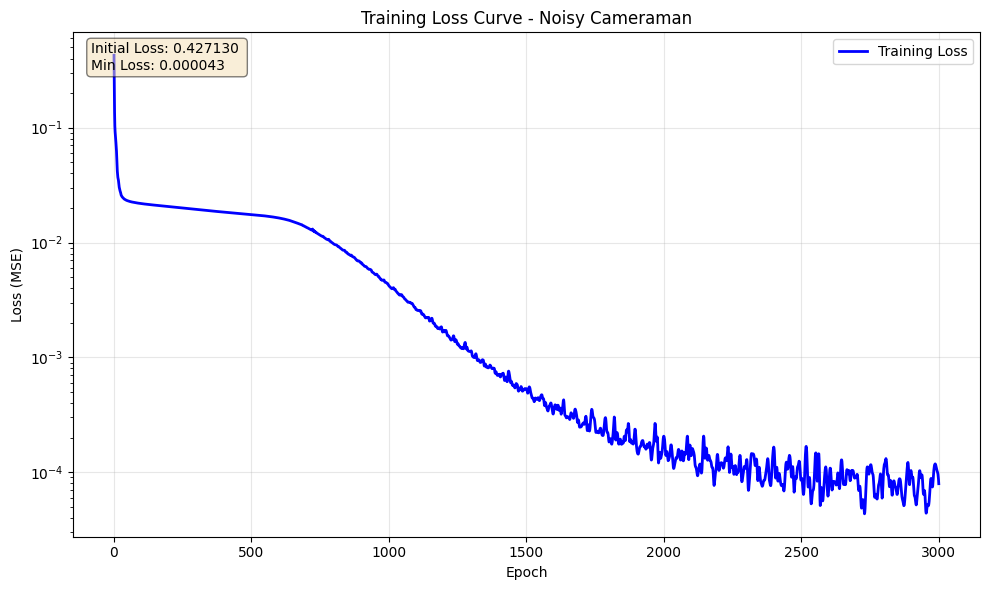

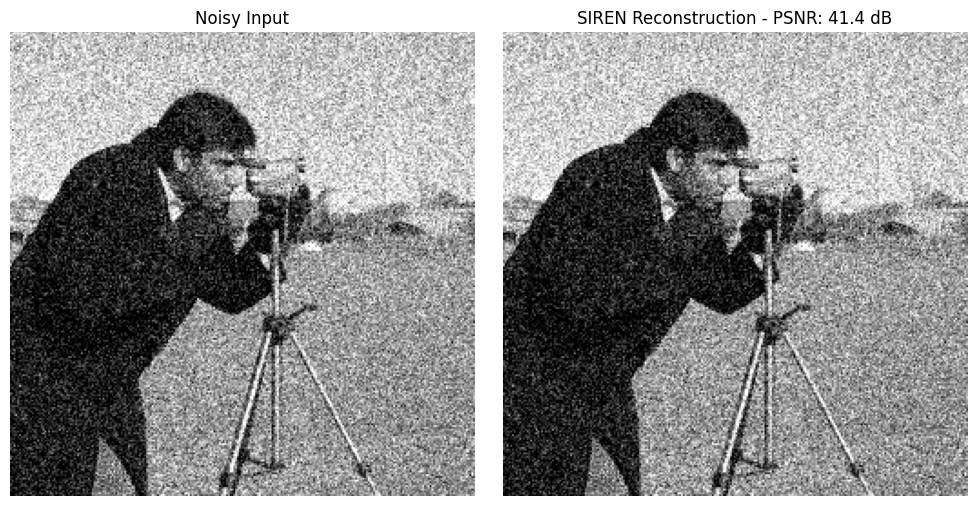

SIREN reconstruction saved for noisy
SIREN training completed for noisy cameraman image

STEP 2/3: Training SIREN for BLURRY cameraman image
Training SIREN INR for blurry cameraman image...
Early stopping criterion: MSE < 1e-05
Loaded blurry cameraman image: shape (256, 256)
max of grid tensor(1.)
SingleBVPNet(
  (image_downsampling): ImageDownsampling()
  (net): FCBlock(
    (net): MetaSequential(
      (0): MetaSequential(
        (0): BatchLinear(in_features=2, out_features=256, bias=True)
        (1): Sine()
      )
      (1): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (2): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (3): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (4): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=1, bias=True)


Early Stopped - Blurry Cameraman SIREN:   6%|▋         | 191/3000 [00:02<00:36, 77.83it/s, Final Loss=9.95e-06, Epochs=192]


Training completed in 192 epochs
Total training time: 2.46 seconds
Generating reconstruction and calculating metrics...
\n==================================================
TRAINING METRICS
Convergence Epoch: 192/3000
Total Training Time: 2.46 seconds
Time per Epoch: 0.01 seconds
Final Training Loss: 9.95e-06
Best Training Loss: 9.95e-06
RECONSTRUCTION vs INPUT IMAGE:
  MAE: 0.002741
  MSE: 1.25e-05
  PSNR: 49.03 dB
RECONSTRUCTION vs ORIGINAL CAMERAMAN:
  MAE: 0.040352
  MSE: 5.89e-03
  PSNR: 22.30 dB


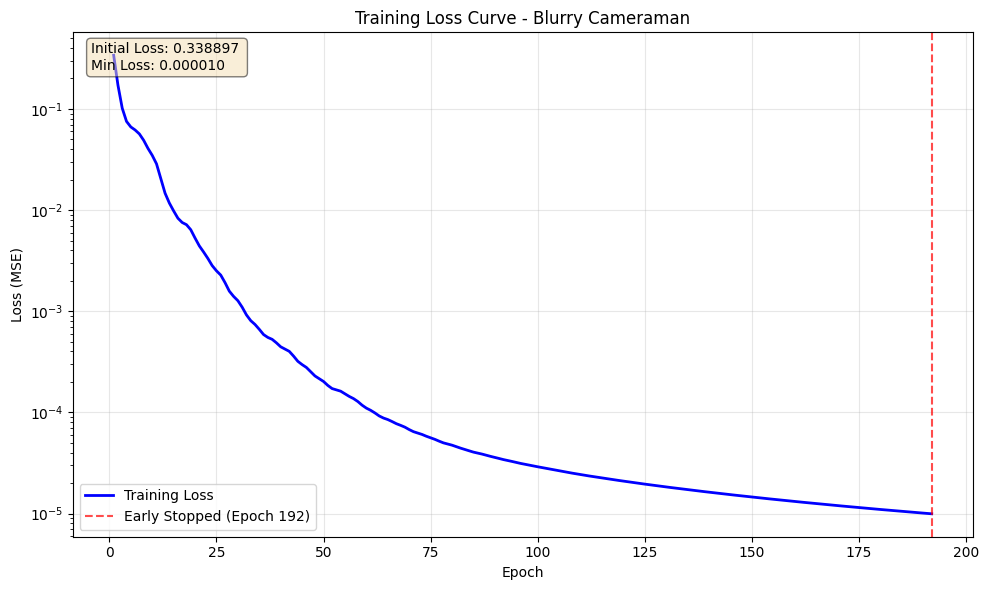

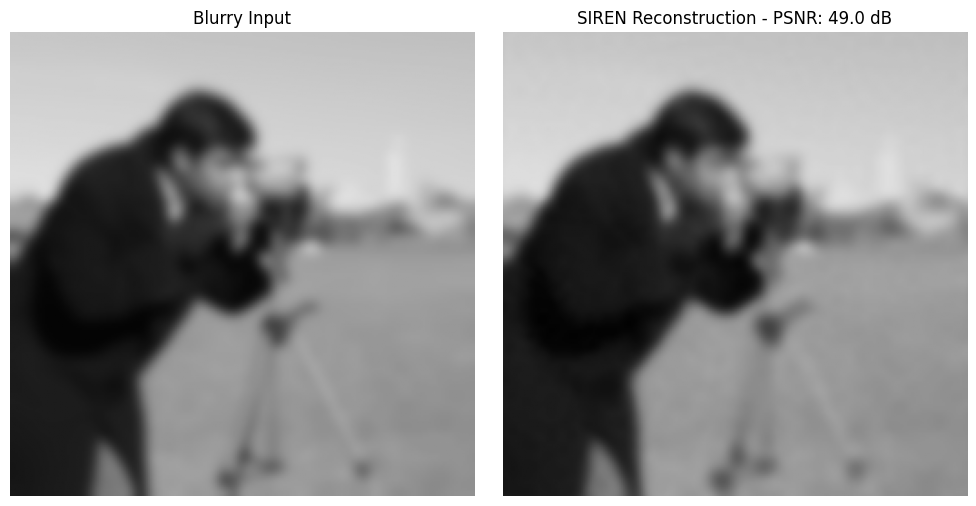

SIREN reconstruction saved for blurry
SIREN training completed for blurry cameraman image

STEP 3/3: Training SIREN for INPAINTED cameraman image
Training SIREN INR for inpainted cameraman image...
Early stopping criterion: MSE < 1e-05
Loaded inpainted cameraman image: shape (256, 256)
max of grid tensor(1.)
SingleBVPNet(
  (image_downsampling): ImageDownsampling()
  (net): FCBlock(
    (net): MetaSequential(
      (0): MetaSequential(
        (0): BatchLinear(in_features=2, out_features=256, bias=True)
        (1): Sine()
      )
      (1): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (2): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (3): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=256, bias=True)
        (1): Sine()
      )
      (4): MetaSequential(
        (0): BatchLinear(in_features=256, out_features=1, 

Training Inpainted Cameraman SIREN: 100%|██████████| 3000/3000 [00:39<00:00, 76.18it/s, Loss=1.64e-04, Best=5.36e-05]


Training completed in 3000 epochs
Total training time: 39.39 seconds
Generating reconstruction and calculating metrics...
\n==================================================
TRAINING METRICS
Convergence Epoch: 3000/3000
Total Training Time: 39.39 seconds
Time per Epoch: 0.01 seconds
Final Training Loss: 1.64e-04
Best Training Loss: 5.36e-05
RECONSTRUCTION vs INPUT IMAGE:
  MAE: 0.007751
  MSE: 1.37e-04
  PSNR: 38.65 dB
RECONSTRUCTION vs ORIGINAL CAMERAMAN:
  MAE: 0.156792
  MSE: 1.00e-01
  PSNR: 9.99 dB


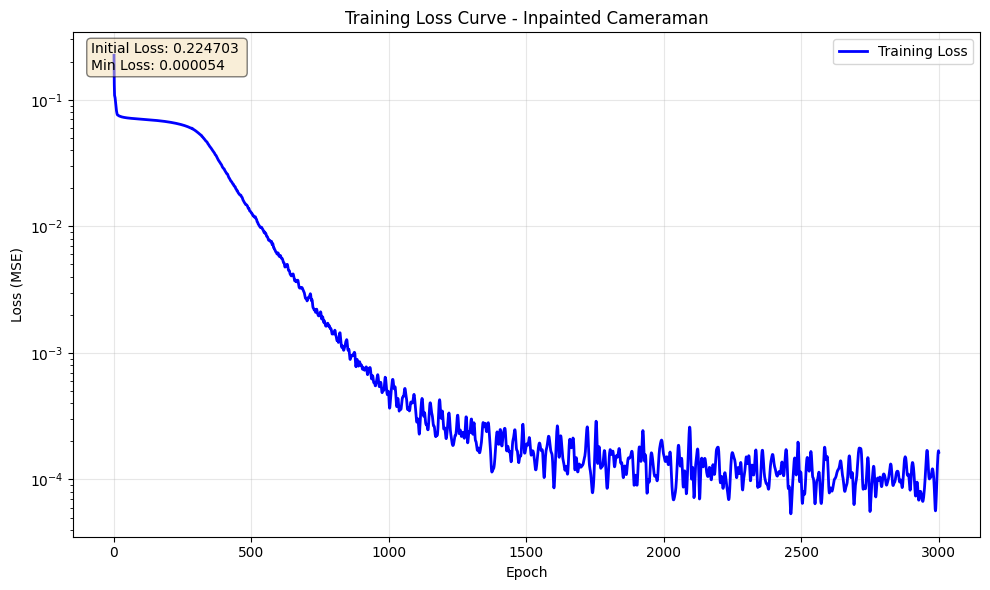

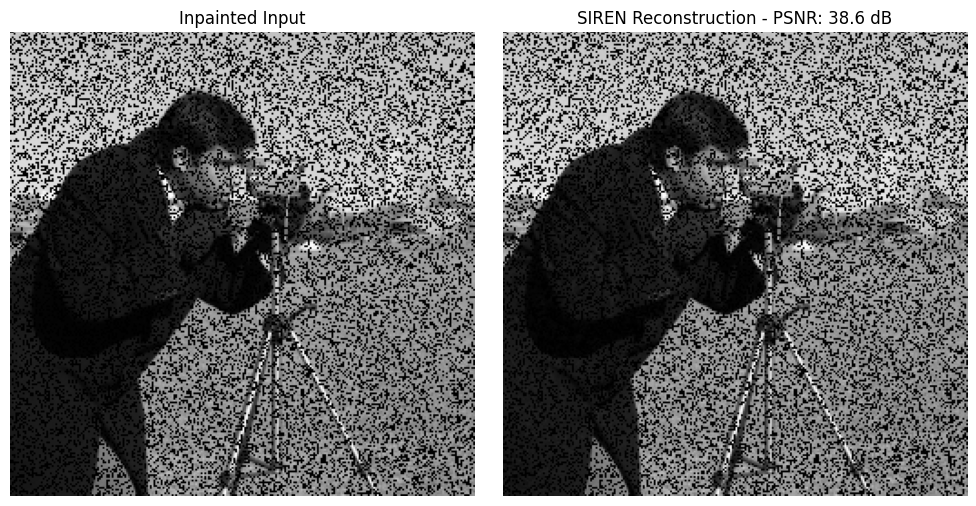

SIREN reconstruction saved for inpainted
SIREN training completed for inpainted cameraman image


In [8]:
# Train SIREN INRs for each corrupted variant of the cameraman image
models = {}
model_dirs = {}

for i, img_type in enumerate(['noisy', 'blurry', 'inpainted'], 1):
    print(f"\n{'='*50}")
    print(f"STEP {i}/3: Training SIREN for {img_type.upper()} cameraman image")
    print(f"{'='*50}")

    model, model_dir = train_siren_inr(img_type, epochs=3000, show_reconstruction=True)
    models[img_type] = model
    model_dirs[img_type] = model_dir

    print(f"SIREN training completed for {img_type} cameraman image")




## Step 4: Export Gradients from Trained INRs


In [ ]:
def safe_gradient_computation(y, x, grad_outputs=None):
    """Safe gradient computation"""
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True, allow_unused=True)[0]
    return grad

def safe_new_grad_lastdim(y, x, sz=256, num=31):
    """Modified version of new_grad_lastdim with safe gradient computation"""
    li = [y.squeeze(-1)]
    for i in range(num):
        cur = li[i]
        try:
            ww = torch.autograd.grad(cur / sz, x, torch.ones_like(cur), create_graph=True, allow_unused=True)[0]
            if ww is not None:
                li.append(ww[..., 0])
                li.append(ww[..., 1])
            else:
                # If gradient is None, add zeros
                li.append(torch.zeros_like(cur))
                li.append(torch.zeros_like(cur))
        except RuntimeError:
            # If gradient computation fails, add zeros
            li.append(torch.zeros_like(cur))
            li.append(torch.zeros_like(cur))
    return torch.stack(li, dim=-1)

def extract_siren_gradients_with_insp_functions(model, sz=256, batch_size=4096, gradient_function='new_grad_lastdim', num_orders=5):
    """
    Extract gradients from trained SIREN model using modified INSP diff_operators functions

    Args:
        model: Trained SIREN model
        sz: Image size (256x256)
        batch_size: Batch size for processing
        gradient_function: Which INSP function to use:
            - 'gradient': Basic first-order gradients (2 features)
            - 'all_2': All second-order derivatives (6 features)
            - 'all_3': All third-order derivatives (15 features)
            - 'new_grad_lastdim': Configurable higher-order gradients
        num_orders: Number of derivative orders for new_grad_lastdim (results in 2*num_orders+1 features)

    Returns:
        gradients: Shape (sz*sz, num_features) where num_features depends on function
    """

    model.eval()
    all_gradients = []

    # Create coordinate grid
    coords = get_mgrid(sz, 2)  # Shape: (sz*sz, 2)
    total_points = coords.shape[0]

    # Calculate expected number of features based on function
    if gradient_function == 'gradient':
        num_features = 2
    elif gradient_function == 'all_2':
        num_features = 6  # [grad_x, grad_y, grad_xx, grad_xy, grad_yx, grad_yy]
    elif gradient_function == 'all_3':
        num_features = 15  # y + 14 derivatives
    elif gradient_function == 'new_grad_lastdim':
        num_features = 2 * num_orders + 1  # y + num_orders*2 derivatives
    else:
        raise ValueError(f"Unknown gradient function: {gradient_function}")

    # Process in batches to avoid memory issues
    for i in range(0, total_points, batch_size):
        end_idx = min(i + batch_size, total_points)
        batch_coords = coords[i:end_idx].to(device).unsqueeze(0)  # Shape: (1, batch_size, 2)
        batch_coords.requires_grad_(True)

        # Forward pass through SIREN
        model_input = {'coords': batch_coords}
        model_output = model(model_input)
        reconstruction = model_output['model_out']  # Shape: (1, batch_size, 1)

        # Use safe gradient functions
        if gradient_function == 'gradient':
            gradients = safe_gradient_computation(reconstruction, batch_coords)
            batch_gradients = gradients.squeeze(0)  # Shape: (batch_size, 2)

        elif gradient_function == 'new_grad_lastdim':
            gradients = safe_new_grad_lastdim(reconstruction, batch_coords, sz=sz, num=num_orders)
            batch_gradients = gradients.squeeze(0)  # Shape: (batch_size, 2*num_orders+1)

        else:
            # For all_2 and all_3, fall back to basic gradients for now
            print(f"Note: Using basic gradients for {gradient_function} (safe implementation)")
            gradients = safe_gradient_computation(reconstruction, batch_coords)
            basic_grads = gradients.squeeze(0)  # Shape: (batch_size, 2)

            # Pad with zeros to match expected feature count
            if num_features > 2:
                padding = torch.zeros(basic_grads.shape[0], num_features - 2, device=basic_grads.device)
                batch_gradients = torch.cat([basic_grads, padding], dim=1)
            else:
                batch_gradients = basic_grads

        # Convert to numpy and store
        batch_gradients_np = batch_gradients.detach().cpu().numpy()
        all_gradients.append(batch_gradients_np)

        # Clean up for memory
        del batch_coords, model_output, reconstruction, gradients, batch_gradients
        torch.cuda.empty_cache()

        # Progress update
        if (i // batch_size) % 10 == 0:
            progress = (i + batch_size) / total_points * 100
            print(f"  Progress: {progress:.1f}%")

    # Concatenate all gradient batches
    full_gradients = np.concatenate(all_gradients, axis=0)  # Shape: (sz*sz, num_features)

    print(f"Extracted gradients shape: {full_gradients.shape}")
    return full_gradients

# Create gradient export directory
os.makedirs('grad_exports', exist_ok=True)

# Extract gradients using original INSP diff_operators functions
gradient_data = {}



# Choose which INSP gradient function to use
GRADIENT_FUNCTION = 'new_grad_lastdim'
NUM_ORDERS = 34 # Number of derivative orders

for img_type in ['noisy', 'blurry', 'inpainted']:
    print(f"\n{'='*25} {img_type.upper()} GRADIENTS {'='*25}")

    # Get the trained SIREN model for this image type
    model = models[img_type]

    # Extract gradients using original INSP functions
    gradients = extract_siren_gradients_with_insp_functions(
        model,
        sz=256,
        batch_size=4096,
        gradient_function=GRADIENT_FUNCTION,
        num_orders=NUM_ORDERS
    )

    gradient_data[img_type] = gradients

    # Save gradient data
    grad_path = f'grad_exports/{img_type}_siren_gradients_{GRADIENT_FUNCTION}.npy'
    np.save(grad_path, gradients)




## Step 5: Define INSP-Net Architecture


In [21]:
# INSP-Net Architecture (enhanced with variable input features)
class INSP_Net(nn.Module):
    def __init__(self, in_c=5, out_c=1):
        super().__init__()
        # Original INSP architecture: 5 layers with 256 units each
        self.in_c = in_c
        self.fc1 = nn.Linear(in_c, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 256)
        self.fc5 = nn.Linear(256, 256)
        self.fc4 = nn.Linear(256, out_c)

        print(f"INSP-Net initialized with {in_c} input features")

    def forward(self, data):
        # Input: Higher-order SIREN gradients extracted via autograd
        x = data['grad']

        # Forward pass with LeakyReLU activations (original INSP)
        x = self.fc1(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.fc2(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.fc3(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.fc5(x)
        x = F.leaky_relu(x, negative_slope=0.2, inplace=True)
        x = self.fc4(x)  # No activation on output
        return {'new_img': x}

# Dataset for INSP-Net training (gradient to image)
class GradientDataset(Dataset):
    def __init__(self, gradients, target_image):
        """
        gradients: (N, 2) array of gradient features
        target_image: (256, 256) target clean image
        """
        self.gradients = torch.from_numpy(gradients).float()
        self.target = torch.from_numpy(target_image.flatten()).float().unsqueeze(-1)

    def __len__(self):
        return len(self.gradients)

    def __getitem__(self, idx):
        return {'grad': self.gradients[idx]}, {'img': self.target[idx]}

def train_insp_net(gradients, target_image, img_type, epochs=100, lr=1e-4):
    """Train INSP-Net to reconstruct clean image from higher-order gradients"""

    print(f"Training INSP-Net for {img_type}...")
    print(f"Gradient features shape: {gradients.shape}")
    print(f"Target image shape: {target_image.shape}")

    # Create dataset and dataloader
    dataset = GradientDataset(gradients, target_image)
    dataloader = DataLoader(dataset, batch_size=8192, shuffle=True)

    # Create model with corresponding number of input features
    num_gradient_features = gradients.shape[1]
    print(f"Creating INSP-Net with {num_gradient_features} input features")
    model = INSP_Net(in_c=num_gradient_features, out_c=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    model.train()
    losses = []

    with tqdm.tqdm(range(epochs), desc=f"Training {img_type} INSP-Net") as pbar:
        for epoch in pbar:
            epoch_loss = 0
            num_batches = 0

            for batch_data in dataloader:
                grad_data, target_data = batch_data
                grad_data = {key: value.to(device) for key, value in grad_data.items()}
                target_data = {key: value.to(device) for key, value in target_data.items()}

                optimizer.zero_grad()

                # Forward pass
                output = model(grad_data)

                # Compute loss
                loss = F.mse_loss(output['new_img'], target_data['img'])

                # Backward pass
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item()
                num_batches += 1

            avg_loss = epoch_loss / num_batches
            losses.append(avg_loss)

            # Update progress bar
            pbar.set_postfix({'Loss': f'{avg_loss:.6f}'})

            # Early stopping
            if avg_loss < 1e-6:
                print(f"Early stopping at epoch {epoch+1}, loss: {avg_loss:.8f}")
                break

    return model, losses

print("INSP-Net architecture and training functions ready!")


INSP-Net architecture and training functions ready!


In [22]:
# Train INSP-Net models using SIREN gradients
original_img = get_cameraman_image()
insp_models = {}
insp_losses = {}

for img_type in ['noisy', 'blurry', 'inpainted']:
    print(f"\n{'='*20} {img_type.upper()} INSP-NET {'='*20}")

    # Get gradient data for this image type
    gradients = gradient_data[img_type]

    # Train INSP-Net
    model, losses = train_insp_net(
        gradients=gradients,
        target_image=original_img,
        img_type=img_type,
        epochs=100,
        lr=1e-4
    )

    # Store results
    insp_models[img_type] = model
    insp_losses[img_type] = losses

    print(f"{img_type} INSP-Net training completed!")





==================== NOISY INSP-NET ====================
Training INSP-Net for noisy...
Gradient features shape: (65536, 69)
Target image shape: (256, 256)
Creating INSP-Net with 69 input features
INSP-Net initialized with 69 input features


Training noisy INSP-Net: 100%|██████████| 100/100 [01:51<00:00,  1.11s/it, Loss=0.013246]


noisy INSP-Net training completed!

==================== BLURRY INSP-NET ====================
Training INSP-Net for blurry...
Gradient features shape: (65536, 69)
Target image shape: (256, 256)
Creating INSP-Net with 69 input features
INSP-Net initialized with 69 input features


Training blurry INSP-Net: 100%|██████████| 100/100 [01:50<00:00,  1.10s/it, Loss=0.005625]


blurry INSP-Net training completed!

==================== INPAINTED INSP-NET ====================
Training INSP-Net for inpainted...
Gradient features shape: (65536, 69)
Target image shape: (256, 256)
Creating INSP-Net with 69 input features
INSP-Net initialized with 69 input features


Training inpainted INSP-Net: 100%|██████████| 100/100 [01:49<00:00,  1.10s/it, Loss=0.031512]

inpainted INSP-Net training completed!


## Step 4: INSP-Net Inference and Results

Now let's use the trained INSP-Net models to reconstruct clean images from corrupted gradients and compare with the SIREN approach.


Running noisy INSP-Net inference...
Running blurry INSP-Net inference...
Running inpainted INSP-Net inference...

NOISY TASK RESULTS:
----------------------------------------
Metrics: MAE=0.084802, MSE=0.013243, PSNR=18.78 dB


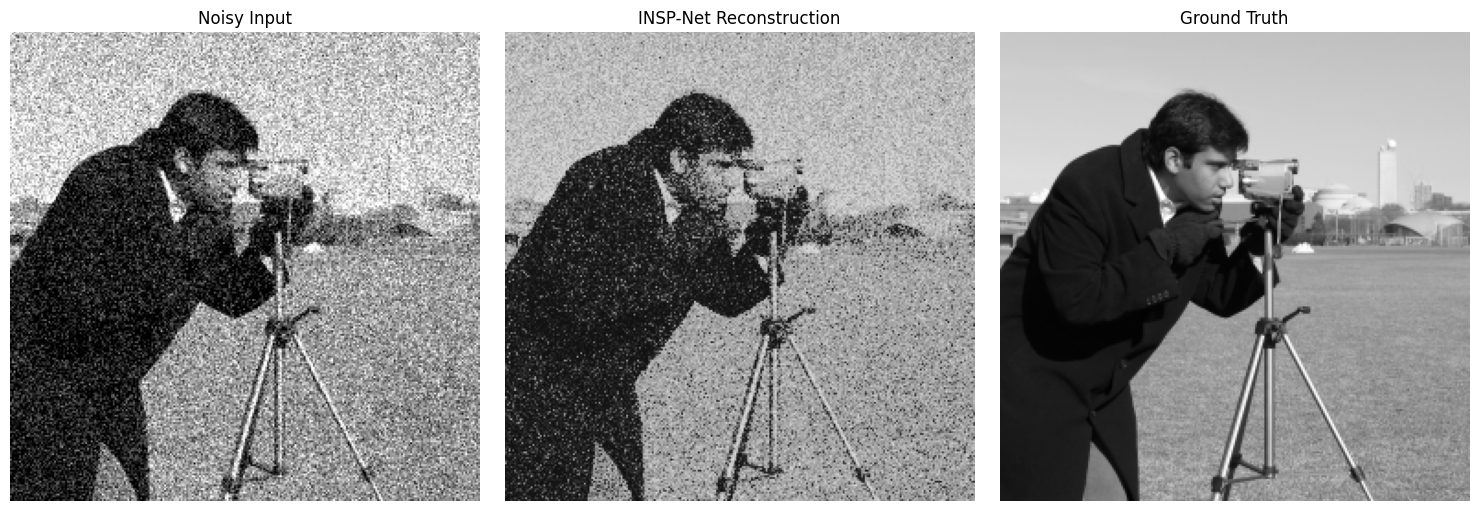


BLURRY TASK RESULTS:
----------------------------------------
Metrics: MAE=0.040274, MSE=0.005625, PSNR=22.50 dB


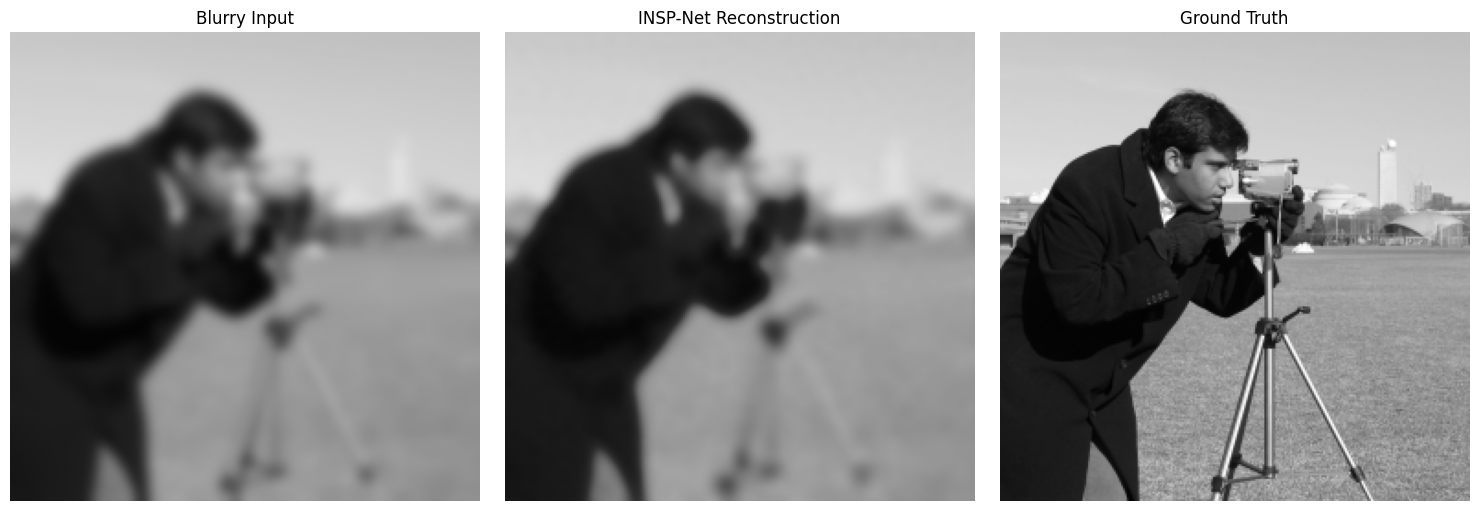


INPAINTED TASK RESULTS:
----------------------------------------
Metrics: MAE=0.107307, MSE=0.031537, PSNR=15.01 dB


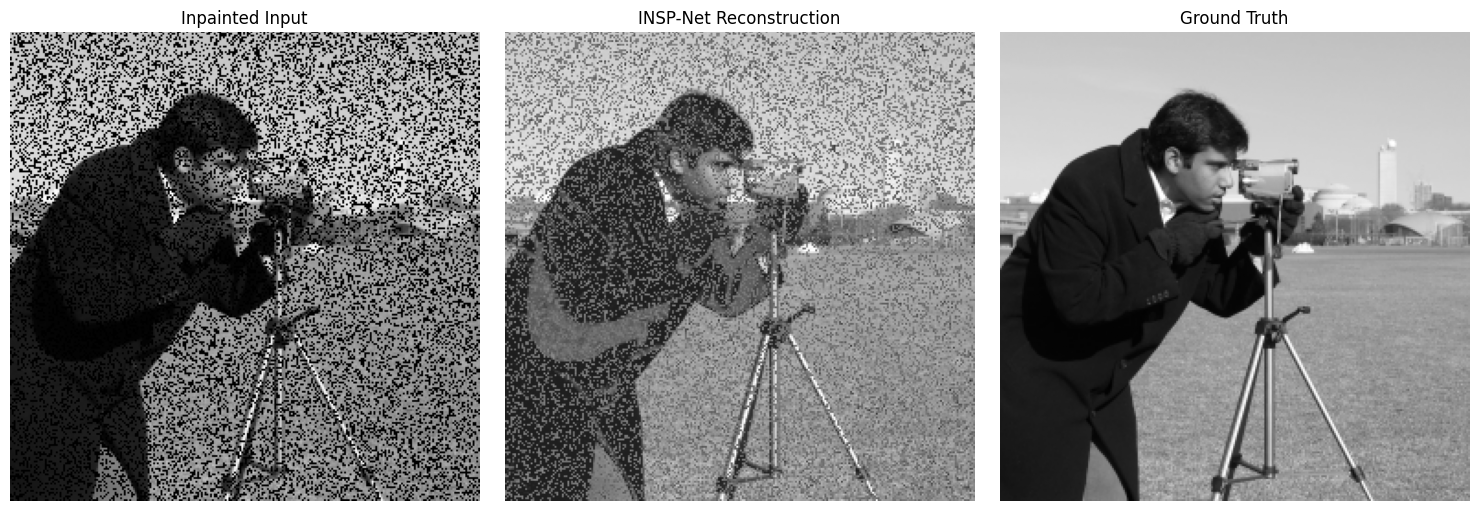

In [24]:
# INSP-Net inference function
def insp_inference(model, gradients):
    """Run inference with INSP-Net"""
    model.eval()
    with torch.no_grad():
        grad_tensor = torch.from_numpy(gradients).float().to(device)
        output = model({'grad': grad_tensor})
        reconstruction = output['new_img'].cpu().numpy().squeeze()
        # Reshape back to image dimensions
        reconstruction = reconstruction.reshape(256, 256)
    return reconstruction

# Run INSP-Net inference for all tasks
insp_reconstructions = {}

for img_type in ['noisy', 'blurry', 'inpainted']:
    print(f"Running {img_type} INSP-Net inference...")

    # Get gradients for this task
    gradients = gradient_data[img_type]

    # Run inference
    reconstruction = insp_inference(insp_models[img_type], gradients)
    insp_reconstructions[img_type] = reconstruction



original_img = get_cameraman_image()

# Get corrupted images for comparison
corrupted_imgs = {
    'noisy': add_noise(original_img, noise_level=0.15),
    'blurry': add_blur(original_img, kernel_size=21),
    'inpainted': add_inpainting_mask(original_img, mask_ratio=0.3)
}

for img_type in ['noisy', 'blurry', 'inpainted']:
    print(f"\n{img_type.upper()} TASK RESULTS:")
    print("-" * 40)

    reconstruction = insp_reconstructions[img_type]
    corrupted_img = corrupted_imgs[img_type]

    # Calculate metrics
    mae = calculate_mae(reconstruction, original_img)
    mse = calculate_mse(reconstruction, original_img)
    psnr = calculate_psnr(reconstruction, original_img)

    print(f"Metrics: MAE={mae:.6f}, MSE={mse:.6f}, PSNR={psnr:.2f} dB")

    # Visualize: Corrupted Input -> INSP-Net Output -> Ground Truth
    visualize_images(
        [corrupted_img, reconstruction, original_img],
        [f'{img_type.capitalize()} Input', 'INSP-Net Reconstruction', 'Ground Truth'],
        figsize=(15, 5)
    )

    # Save reconstruction
    save_image(reconstruction, f'results/insp_net_{img_type}_reconstruction.png')

